# **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install sympy==1.12


In [2]:

import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os


In [3]:
IMAGES_ROOT = "/content/Aerial_Landscapes/Aerial_Landscapes"
IMAGE_SIZE = (128, 128)


In [4]:
image_paths = glob.glob(os.path.join(IMAGES_ROOT, "**", "*.*"), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith((".jpg", ".jpeg", ".png"))]

print("Total images found:", len(image_paths))
print("Example:", image_paths[0])


Total images found: 12000
Example: /content/Aerial_Landscapes/Aerial_Landscapes/Forest/581.jpg


In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype(np.float32) / 255.0
    return img


In [6]:
def create_mask_from_green(img):
    """
    img: صورة بعد الـ preprocess (128x128x3, قيم 0-1)
    نشتغل في HSV عشان نمسك الأخضر الفاتح والغامق.
    """


    img_uint8 = (img * 255).astype(np.uint8)


    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)


    lower_green = np.array([35, 40, 25], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_green, upper_green)


    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)


    mask = (mask > 0).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask


In [7]:
images_list = []
masks_list  = []

print("Re-generating masks with new green thresholds ...")

for p in tqdm(image_paths):
    img  = preprocess_image(p)
    mask = create_mask_from_green(img)

    images_list.append(img)
    masks_list.append(mask)

images = np.stack(images_list, axis=0).astype(np.float32)
masks  = np.stack(masks_list,  axis=0).astype(np.float32)

print("Images shape:", images.shape)
print("Masks  shape:", masks.shape)


Re-generating masks with new green thresholds ...


100%|██████████| 12000/12000 [00:17<00:00, 674.29it/s]


Images shape: (12000, 128, 128, 3)
Masks  shape: (12000, 128, 128, 1)


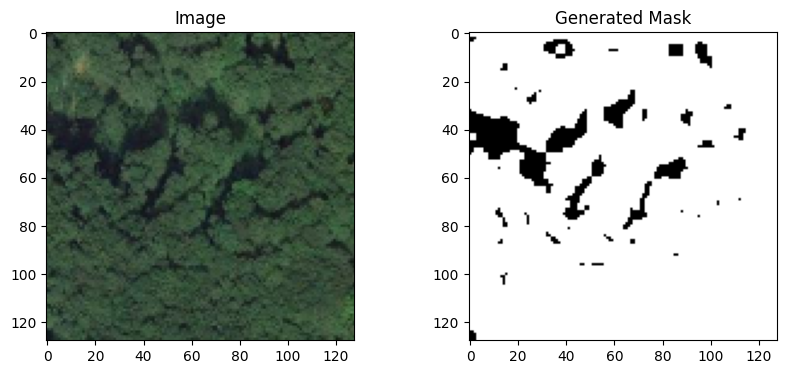

In [8]:
idx = 0
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(images[idx])
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(masks[idx][:,:,0], cmap="gray")
plt.title("Generated Mask")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train images:", X_train.shape, "Train masks:", y_train.shape)
print("Val   images:", X_val.shape,   "Val   masks:",   y_val.shape)



Train images: (9600, 128, 128, 3) Train masks: (9600, 128, 128, 1)
Val   images: (2400, 128, 128, 3) Val   masks: (2400, 128, 128, 1)


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class AgriDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img  = self.images[idx]
        mask = self.masks[idx]


        img  = img.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        img_t  = torch.tensor(img,  dtype=torch.float32)
        mask_t = torch.tensor(mask, dtype=torch.float32)

        return img_t, mask_t

train_dataset = AgriDataset(X_train, y_train)
val_dataset   = AgriDataset(X_val,   y_val)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print("Batches train:", len(train_loader), "Batches val:", len(val_loader))


Batches train: 1200 Batches val: 300


In [11]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(3, 16)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(32, 64)

        self.up2   = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)

        self.up1   = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv1 = DoubleConv(32, 16)

        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        b = self.bridge(p2)

        u2 = self.up2(b)
        m2 = torch.cat([u2, c2], dim=1)
        c4 = self.conv2(m2)

        u1 = self.up1(c4)
        m1 = torch.cat([u1, c1], dim=1)
        c5 = self.conv1(m1)

        out = torch.sigmoid(self.final(c5))
        return out


In [12]:
def calc_metrics(preds, masks, thresh=0.5):
    preds_bin = (preds >= thresh).float()

    correct = (preds_bin == masks).float().sum()
    total   = masks.numel()
    acc = correct / total

    intersection = (preds_bin * masks).sum()
    union        = preds_bin.sum() + masks.sum() - intersection

    iou  = (intersection + 1e-6) / (union + 1e-6)
    dice = (2 * intersection + 1e-6) / (preds_bin.sum() + masks.sum() + 1e-6)

    return acc.item(), iou.item(), dice.item()


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20

for epoch in range(EPOCHS):
    # ---- train ----
    model.train()
    train_loss = 0.0

    for imgs, masks in train_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        loss  = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)


    model.eval()
    val_acc = 0
    val_iou = 0
    val_loss = 0
    val_dice = 0
    batches = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            acc, iou, dice = calc_metrics(preds, masks)

            val_acc  += acc
            val_iou  += iou
            val_dice += dice
            batches += 1

    val_acc  /= batches
    val_iou  /= batches
    val_dice /= batches

print(
    f"Epoch {epoch+1}/{EPOCHS} - "
    f"Train Loss: {train_loss:.4f} - "
    f"Val Loss: {val_loss:.4f} - "
    f"Acc: {val_acc*100:.2f}% - "
    f"IoU: {val_iou*100:.2f}% - "
    f"Dice: {val_dice*100:.2f}%"
)



Device: cuda
Epoch 20/20 - Train Loss: 0.0426 - Val Loss: 0.0000 - Acc: 98.27% - IoU: 93.39% - Dice: 96.55%


In [14]:
def compute_gvi(img, pred_mask_bin):

    veg_pixels = img[pred_mask_bin[:,:,0] == 1]
    if veg_pixels.size == 0:
        return 0.0
    g_channel = veg_pixels[:, 1]
    return float(g_channel.mean())


In [21]:
def irrigation_advice(prop_agri, gvi):
    """
    prop_agri: نسبة الغطاء النباتي (0–1)
    gvi: مؤشر صحة النبات (0–1)
    """

    # ---- 1) صحراء تقريبًا ----
    if prop_agri < 0.05:
        return "🟤 المنطقة معظمها صحراء، لا حاجة للري أو الزراعة محدودة."

    # ---- 2) غطاء نباتي كثيف جدًا (غابات) Regardless of GVI ----
    if prop_agri > 0.70:
        return "🟢 الغطاء النباتي كثيف وصحي بشكل عام، لا حاجة لزيادة الري."

    # ---- 3) مناطق زراعية متوسطة أو منخفضة ----
    if gvi > 0.55:
        return "🟢 الغطاء النباتي صحي، يمكن تقليل الري لتجنب هدر المياه."
    elif gvi > 0.35:
        return "🟡 حالة متوسطة، يُنصح بري منتظم بكمية معتدلة."
    else:
        return "🔴 إجهاد واضح في النباتات، يُنصح بزيادة الري وفحص التربة ونوعية المياه."



In [22]:
def show_prediction(img, pred_mask):
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    overlay = (img*255).astype(np.uint8).copy()
    overlay[pred_mask_bin[:,:,0] == 1] = (
        overlay[pred_mask_bin[:,:,0] == 1] * 0.4 +
        np.array([0,255,0]) * 0.6
    ).astype(np.uint8)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow((img*255).astype(np.uint8))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(pred_mask[:,:,0], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay (Green = Vegetation)")
    plt.axis("off")

    plt.show()


In [23]:
def predict_image(img_path):

    img = preprocess_image(img_path)
    img_t = torch.tensor(img.transpose(2,0,1), dtype=torch.float32).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        pred = model(img_t)[0].cpu().numpy()
    pred = np.transpose(pred, (1,2,0))


    pred_mask_bin = (pred > 0.5).astype(np.uint8)

    prop_agri = np.sum(pred_mask_bin) / (pred_mask_bin.shape[0]*pred_mask_bin.shape[1])
    gvi = compute_gvi(img, pred_mask_bin)
    advice = irrigation_advice(prop_agri, gvi)

    print(f"📊 Green area ratio: {prop_agri*100:.2f}%")
    print(f"🌿 GVI: {gvi:.3f}")
    print(advice)
    show_prediction(img, pred)


📊 Green area ratio: 0.00%
🌿 GVI: 0.000
🟤 المنطقة معظمها صحراء، لا حاجة للري أو الزراعة محدودة.


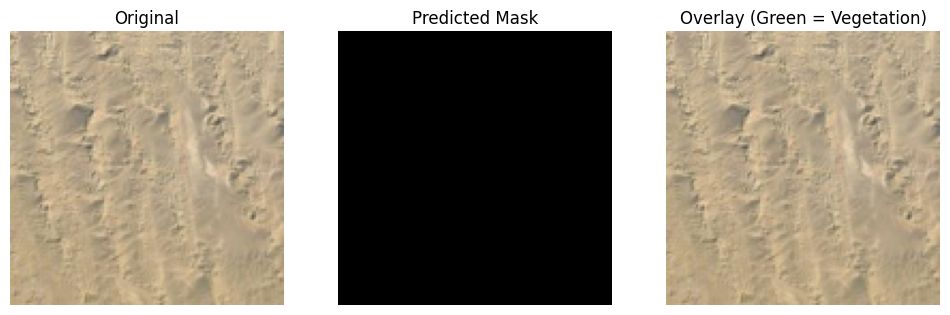

In [41]:
test_img_path = image_paths[2220]
predict_image(test_img_path)


In [29]:
torch.save(model.state_dict(), "desert_agri_unet_weights.pth")
print("✅ Model weights saved!")


✅ Model weights saved!


In [34]:
!cp desert_agri_unet_weights.pth "/content/drive/MyDrive/desert_agri_unet_weights.pth"
print("✔️ Model uploaded to Google Drive!")



✔️ Model uploaded to Google Drive!
